<a href="https://colab.research.google.com/github/Droid008/PyTorch-framework-for-the-development-of-artificial-neural-networks/blob/Lesson-%236/HW-%236.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import datetime as dt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Загрузка данных

In [2]:
data_train = fetch_20newsgroups(subset='train', 
                                shuffle=True, random_state=42)

data_test = fetch_20newsgroups(subset='test', 
                               shuffle=False)

In [3]:
df_train, df_val, y_train, y_val = train_test_split(pd.DataFrame(data_train.data, columns=['text']),
                                                    data_train.target,
                                                    test_size=0.3, random_state=42)

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

df_test = pd.DataFrame(data_test.data, columns=['text'])
y_test = data_test.target

### Предобработка

In [12]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

nltk.download("punkt")

sw = set(get_stop_words("en"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [14]:
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [15]:
tokens = word_tokenize(train_corpus)

In [16]:
tokens_filtered = [word for word in tokens if word.isalnum()]
dist = FreqDist(tokens_filtered)

In [17]:
def get_vocabulary(max_words):
    tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
    vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
    return vocabulary

In [18]:
def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [19]:
def prepare_data(max_words, max_len):
    vocabulary = get_vocabulary(max_words)
    x_train = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_train["text"]], dtype=np.int32)
    x_val = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_val["text"]], dtype=np.int32)
    x_test = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_test["text"]], dtype=np.int32)
    print(f'x_train.shape: {x_train.shape}')
    print(f'x_val.shape: {x_val.shape}')
    print(f'x_test.shape: {x_test.shape}')
    return x_train, x_val, x_test, vocabulary

### Модель

In [20]:
import random
import torch
import torch.nn as nn

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [23]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        if self.target is not None:
            y = np.zeros(20, dtype=float)
            y[self.target[index]] = 1
        else:
            y = None
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [24]:
class Trainer():
    """
    Parameters:
        dataset: пользовательский класс, предобрабатывающий данные
        train_preprocessing: преобразования тренировочных данных
        valid_preprocessing: преобразования валидационных данных
        
        loss_f: функция потерь
        learning_rate: величина градиентного шага
        epoch_amount: общее количество эпох
        batch_size: размер одного бача
        max_batches_per_epoch: максимальное количество батчей, 
                               подаваемых в модель в одну эпоху
        device: устройство для вычислений
        early_stopping: количество эпох без улучшений до остановки обучения
        
        optim: оптимизатор
        params_to_update: список обучаемых параметров
        
        scheduler: регулятор градиентного шага
        permutate: перемешивание тренировочной выборки перед обучением

    Attributes:
        start_model: необученная модель
        best_model: модель, после обучения
        train_loss: средние значения функции потерь на тренировочных 
                    данных в каждой эпохе
        val_loss: средние значения функции потерь на валидационных 
                  данных в каждой эпохе

    Methods:
        fit: обучение модели
        predict: возвращает предсказание обученной моделью

    """
    def __init__(self,  dataset, net, loss_f,
                 train_preprocessing=None,
                 valid_preprocessing=None,
                 learning_rate=1e-3, 
                 epoch_amount=10, batch_size=12,
                 max_batches_per_epoch=None,
                 device='cpu', early_stopping=10,
                 optim=torch.optim.Adam,
                 params_to_update=None,
                 scheduler=None, permutate=True):
        
        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        
        self.optim = optim
        self.params_to_update = params_to_update
        
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.train_preprocessing = train_preprocessing
        self.valid_preprocessing = valid_preprocessing
        
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []
    
    def predict(self, X):
        return self.best_model(X)

    def fit(self, train_dataset, train_labels, valid_dataset, valid_labels):

        Net = self.start_model
            
        device = torch.device(self.device)

        Net.to(self.device)

        if self.params_to_update is not None:
            optimizer = self.optim(self.params_to_update, lr=self.learning_rate)
        else:
            optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        train = self.dataset(train_dataset, train_labels, self.train_preprocessing)
        val = self.dataset(valid_dataset, valid_labels, self.valid_preprocessing)  

        train = DataLoader(train, batch_size=self.batch_size, shuffle=self.permutate) 
        val = DataLoader(val, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf') # Лучшее значение функции потерь на валидационной выборке
        best_ep = 0                  # Эпоха, на которой достигалось лучшее 
                                     # значение функции потерь на валидационной выборке

        for epoch in range(self.epoch_amount): 
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0
            batch_n = 0

            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break
                optimizer.zero_grad()

                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            Net.eval()
            mean_loss = 0
            batch_n = 0

            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

    def save_model(self, PATH):
        torch.save(self.best_model.state_dict(), PATH)

    def load_model(self, PATH):
         self.best_model.load_state_dict(torch.load(PATH))       
        
    def get_clf_results(self, test_dataset, test_labels):
        test = self.dataset(test_dataset, test_labels, self.valid_preprocessing)
        test = DataLoader(test, batch_size=self.batch_size, shuffle=False)
        
        true_labels = []
        pred_labels = []
        with torch.no_grad():
            for batch_X, labels in test:
                true_labels += list(labels.numpy())
                batch_X = batch_X.to(self.device)
                labels = labels.to(self.device)

                outputs = self.predict(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                
                pred_labels += list(predicted.numpy())
        return true_labels, pred_labels 

### Вариант #1

In [25]:
net = Net(vocab_size=2000, num_classes=20)

print(net)
print("Parameters:", sum([param.nelement() for param in net.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=20, bias=True)
)
Parameters: 307860


In [26]:
x_train, x_val, x_test, vocabulary = prepare_data(2000, 40)

x_train.shape: (7919, 40)
x_val.shape: (3395, 40)
x_test.shape: (7532, 40)


In [27]:
params = {
    'dataset': DataWrapper,
    'net': net,
    'batch_size': 128,
    'epoch_amount': 20, 
    'learning_rate': 1e-3,
    'early_stopping': 5,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.Adam,
    'device': device
}

clf1 = Trainer(**params)

In [28]:
clf1.fit(x_train, y_train, x_val, y_val)

Эпоха: 0 Loss_train: 2.892475143555672, 0:00:03.572712 сек
Loss_val: 2.591214895248413

Эпоха: 1 Loss_train: 2.3922681962290118, 0:00:03.361392 сек
Loss_val: 2.1619837284088135

Эпоха: 2 Loss_train: 1.8975751669176164, 0:00:03.606093 сек
Loss_val: 1.8822054862976074

Эпоха: 3 Loss_train: 1.5005450267945566, 0:00:03.262083 сек
Loss_val: 1.5828734636306763

Эпоха: 4 Loss_train: 1.1915070299179322, 0:00:03.257285 сек
Loss_val: 1.3665105104446411

Эпоха: 5 Loss_train: 0.9486455840449179, 0:00:04.071181 сек
Loss_val: 1.2781072854995728

Эпоха: 6 Loss_train: 0.7464382485035927, 0:00:03.280576 сек
Loss_val: 1.1642943620681763

Эпоха: 7 Loss_train: 0.5870071947574615, 0:00:03.286393 сек
Loss_val: 1.110813021659851

Эпоха: 8 Loss_train: 0.45350837467178223, 0:00:03.281544 сек
Loss_val: 1.0735477209091187

Эпоха: 9 Loss_train: 0.3504411929076718, 0:00:03.221779 сек
Loss_val: 1.0738521814346313

Эпоха: 10 Loss_train: 0.2677027828270389, 0:00:03.180875 сек
Loss_val: 1.0093069076538086

Эпоха: 11 L

In [29]:
true_labels, pred_labels = clf1.get_clf_results(x_test, y_test)

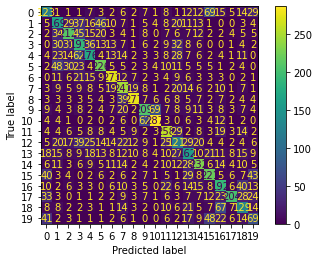

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, pred_labels))
disp.plot()

In [31]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.38      0.39      0.38       319
           1       0.42      0.43      0.43       389
           2       0.55      0.54      0.54       394
           3       0.41      0.49      0.45       392
           4       0.49      0.46      0.48       385
           5       0.59      0.57      0.58       395
           6       0.68      0.70      0.69       390
           7       0.53      0.62      0.57       396
           8       0.77      0.70      0.73       398
           9       0.57      0.53      0.55       397
          10       0.73      0.72      0.73       399
          11       0.61      0.65      0.63       396
          12       0.35      0.31      0.33       393
          13       0.41      0.41      0.41       396
          14       0.58      0.59      0.59       394
          15       0.52      0.56      0.54       398
          16       0.46      0.53      0.49       364
          17       0.77    

### Вариант #2

In [32]:
net = Net(vocab_size=2000, embedding_dim=256, out_channel=256, num_classes=20)

print(net)
print("Parameters:", sum([param.nelement() for param in net.parameters()]))

Net(
  (embedding): Embedding(2000, 256)
  (conv): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=256, out_features=20, bias=True)
)
Parameters: 714004


In [33]:
params = {
    'dataset': DataWrapper,
    'net': net,
    'batch_size': 128,
    'epoch_amount': 20, 
    'learning_rate': 1e-3,
    'early_stopping': 5,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.Adam,
    'device': device
}

clf2 = Trainer(**params)

In [34]:
clf2.fit(x_train, y_train, x_val, y_val)

Эпоха: 0 Loss_train: 2.6708356949590866, 0:00:09.935897 сек
Loss_val: 2.14377498626709

Эпоха: 1 Loss_train: 1.6179586072121896, 0:00:09.857116 сек
Loss_val: 1.5809332132339478

Эпоха: 2 Loss_train: 1.0092092656320142, 0:00:09.817006 сек
Loss_val: 1.3944604396820068

Эпоха: 3 Loss_train: 0.6202031547023404, 0:00:09.807962 сек
Loss_val: 1.309485673904419

Эпоха: 4 Loss_train: 0.3532640188932419, 0:00:09.857002 сек
Loss_val: 1.1890579462051392

Эпоха: 5 Loss_train: 0.19459789727003343, 0:00:09.886653 сек
Loss_val: 1.2002849578857422

Эпоха: 6 Loss_train: 0.11084881364818543, 0:00:09.871690 сек
Loss_val: 1.2118855714797974

Эпоха: 7 Loss_train: 0.0712860738558154, 0:00:09.931458 сек
Loss_val: 1.2346032857894897

Эпоха: 8 Loss_train: 0.05055072855564856, 0:00:09.986537 сек
Loss_val: 1.2610664367675781

Эпоха: 9 Loss_train: 0.03808978722701149, 0:00:09.836431 сек
Loss_val: 1.2437304258346558

Эпоха: 10 Loss_train: 0.031247835876720566, 0:00:09.940857 сек
Loss_val: 1.2571775913238525
5 без у

In [35]:
true_labels, pred_labels = clf2.get_clf_results(x_test, y_test)

In [36]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.44      0.50      0.47       319
           1       0.51      0.54      0.53       389
           2       0.59      0.59      0.59       394
           3       0.53      0.47      0.50       392
           4       0.64      0.54      0.59       385
           5       0.63      0.65      0.64       395
           6       0.79      0.70      0.74       390
           7       0.58      0.66      0.62       396
           8       0.77      0.78      0.77       398
           9       0.61      0.62      0.62       397
          10       0.76      0.73      0.74       399
          11       0.68      0.69      0.69       396
          12       0.35      0.48      0.40       393
          13       0.57      0.54      0.55       396
          14       0.64      0.64      0.64       394
          15       0.60      0.56      0.58       398
          16       0.52      0.58      0.55       364
          17       0.79    

### Вариант #3

In [37]:
net = Net(vocab_size=2000, num_classes=20)

print(net)
print("Parameters:", sum([param.nelement() for param in net.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=20, bias=True)
)
Parameters: 307860


In [38]:
x_train, x_val, x_test, vocabulary = prepare_data(2000, 60)

x_train.shape: (7919, 60)
x_val.shape: (3395, 60)
x_test.shape: (7532, 60)


In [39]:
params = {
    'dataset': DataWrapper,
    'net': net,
    'batch_size': 128,
    'epoch_amount': 20, 
    'learning_rate': 1e-3,
    'early_stopping': 5,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.Adam,
    'device': device
}

clf3 = Trainer(**params)

In [40]:
clf3.fit(x_train, y_train, x_val, y_val)

Эпоха: 0 Loss_train: 2.8631850634851763, 0:00:04.489164 сек
Loss_val: 2.559260129928589

Эпоха: 1 Loss_train: 2.3190675089436192, 0:00:04.408538 сек
Loss_val: 2.03096604347229

Эпоха: 2 Loss_train: 1.7641141972234171, 0:00:04.491214 сек
Loss_val: 1.6068027019500732

Эпоха: 3 Loss_train: 1.358329669121773, 0:00:04.423744 сек
Loss_val: 1.4130585193634033

Эпоха: 4 Loss_train: 1.0650692072606855, 0:00:04.393924 сек
Loss_val: 1.232444167137146

Эпоха: 5 Loss_train: 0.8416009852963109, 0:00:04.253780 сек
Loss_val: 1.222477912902832

Эпоха: 6 Loss_train: 0.6623941260960794, 0:00:04.394771 сек
Loss_val: 1.0982449054718018

Эпоха: 7 Loss_train: 0.5169376163713394, 0:00:04.430582 сек
Loss_val: 1.0848164558410645

Эпоха: 8 Loss_train: 0.40182133115107016, 0:00:04.350635 сек
Loss_val: 1.0206217765808105

Эпоха: 9 Loss_train: 0.3078906543312534, 0:00:04.415697 сек
Loss_val: 1.004296898841858

Эпоха: 10 Loss_train: 0.23631066997205058, 0:00:04.374960 сек
Loss_val: 1.0645560026168823

Эпоха: 11 Loss

In [41]:
true_labels, pred_labels = clf3.get_clf_results(x_test, y_test)

In [42]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.47      0.54      0.50       319
           1       0.55      0.51      0.53       389
           2       0.57      0.61      0.59       394
           3       0.51      0.51      0.51       392
           4       0.59      0.60      0.60       385
           5       0.68      0.61      0.64       395
           6       0.72      0.73      0.73       390
           7       0.61      0.65      0.63       396
           8       0.78      0.77      0.78       398
           9       0.65      0.62      0.64       397
          10       0.78      0.76      0.77       399
          11       0.72      0.72      0.72       396
          12       0.38      0.44      0.41       393
          13       0.50      0.49      0.50       396
          14       0.65      0.63      0.64       394
          15       0.59      0.63      0.61       398
          16       0.53      0.59      0.55       364
          17       0.86    

### Вариант #4

In [43]:
net = Net(vocab_size=4000, embedding_dim=256, out_channel=256, num_classes=20)

print(net)
print("Parameters:", sum([param.nelement() for param in net.parameters()]))

Net(
  (embedding): Embedding(4000, 256)
  (conv): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=256, out_features=20, bias=True)
)
Parameters: 1226004


In [44]:
x_train, x_val, x_test, vocabulary = prepare_data(4000, 60)

x_train.shape: (7919, 60)
x_val.shape: (3395, 60)
x_test.shape: (7532, 60)


In [45]:
params = {
    'dataset': DataWrapper,
    'net': net,
    'batch_size': 128,
    'epoch_amount': 20, 
    'learning_rate': 1e-3,
    'early_stopping': 5,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.Adam,
    'device': device
}

clf4 = Trainer(**params)

In [46]:
clf4.fit(x_train, y_train, x_val, y_val)

Эпоха: 0 Loss_train: 2.6810216519140426, 0:00:14.037826 сек
Loss_val: 2.0264434814453125

Эпоха: 1 Loss_train: 1.607700276759363, 0:00:13.697669 сек
Loss_val: 1.4018487930297852

Эпоха: 2 Loss_train: 0.9716778013014025, 0:00:13.927552 сек
Loss_val: 1.1034209728240967

Эпоха: 3 Loss_train: 0.5739466672943484, 0:00:13.974526 сек
Loss_val: 0.9939522743225098

Эпоха: 4 Loss_train: 0.3124633599673548, 0:00:13.934683 сек
Loss_val: 0.8584520220756531

Эпоха: 5 Loss_train: 0.16375134044116543, 0:00:13.957742 сек
Loss_val: 0.8135885000228882

Эпоха: 6 Loss_train: 0.09388948928925299, 0:00:15.106910 сек
Loss_val: 0.7961558103561401

Эпоха: 7 Loss_train: 0.06035969724818584, 0:00:27.587084 сек
Loss_val: 0.8057540059089661

Эпоха: 8 Loss_train: 0.0427433799111074, 0:00:14.107857 сек
Loss_val: 0.8036873936653137

Эпоха: 9 Loss_train: 0.0324480680508479, 0:00:13.988014 сек
Loss_val: 0.76949542760849

Эпоха: 10 Loss_train: 0.025165556329152277, 0:00:14.252213 сек
Loss_val: 0.7718759775161743

Эпоха: 

In [47]:
true_labels, pred_labels = clf4.get_clf_results(x_test, y_test)

In [48]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.47      0.48      0.48       319
           1       0.54      0.60      0.57       389
           2       0.66      0.62      0.64       394
           3       0.53      0.56      0.55       392
           4       0.66      0.62      0.64       385
           5       0.68      0.69      0.69       395
           6       0.82      0.68      0.74       390
           7       0.65      0.69      0.67       396
           8       0.79      0.79      0.79       398
           9       0.67      0.69      0.68       397
          10       0.81      0.81      0.81       399
          11       0.77      0.74      0.75       396
          12       0.40      0.51      0.45       393
          13       0.62      0.57      0.59       396
          14       0.80      0.70      0.75       394
          15       0.61      0.70      0.65       398
          16       0.62      0.64      0.63       364
          17       0.86    

In [49]:
def plot_loss():
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(clf1.train_loss)), clf1.train_loss, label='train 1', linestyle='--')
    plt.plot(range(len(clf1.val_loss)), clf1.val_loss, marker='o', label='val 1')
    plt.plot(range(len(clf2.train_loss)), clf2.train_loss, label='train 2', linestyle='--')
    plt.plot(range(len(clf2.val_loss)), clf2.val_loss, marker='o', label='val 2')
    plt.plot(range(len(clf3.train_loss)), clf3.train_loss, label='train 3', linestyle='--')
    plt.plot(range(len(clf3.val_loss)), clf3.val_loss, marker='o', label='val 3')
    plt.plot(range(len(clf4.train_loss)), clf4.train_loss, label='train 4', linestyle='--')
    plt.plot(range(len(clf4.val_loss)), clf4.val_loss, marker='o', label='val 4')
    plt.legend()
    plt.show()

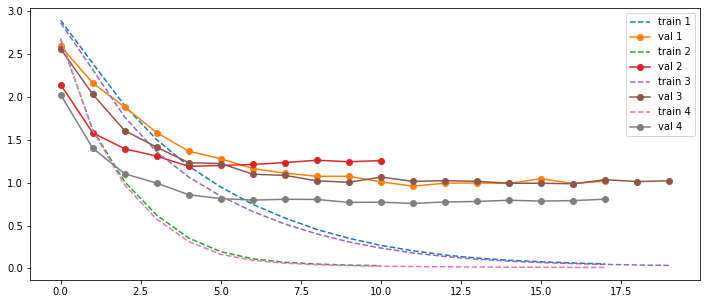

In [50]:
plot_loss()